####ALL IMPORTS

In [1]:
import os
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle
from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary


import torch; 
torch.backends.mps.is_available()

True

In [2]:
d = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    d = "mps"
elif torch.cuda.is_available():
    d = "cuda:0"
device = torch.device(d)

print("Device: {}".format(device))

Device: mps


In [3]:
%ls

Archive/
Archive.zip
Archive_2/
Euro sat - Resnet 30 epochs without weights Transfer Learning.ipynb
Euro sat - Resnet 30 epochs without weights- Transfer Learning with 13 bands.ipynb
Euro sat - Resnet 30 epochs without weights.ipynb
Euro_sat_VGG.ipynb
PLANET_IMAGE_CLASSIFICATION RESNET.ipynb
PLANET_IMAGE_CLASSIFICATION-DENSENET121.ipynb
PLANET_IMAGE_CLASSIFICATION-VGG16.ipynb
PlanetDataset/
Satellite_Classification_using_RESNET-TSNE.ipynb
Satellite_Classification_using_RESNET-oop.ipynb
Transfer_Learning_Satellite_Classification_using_RESNET.ipynb
densenet.pth
resnet.pth
rsicb_densenet.ipynb
sat_data_vgg_op.ipynb
train_results.pkl
train_results_densnet.pkl


In [4]:
data_dir = './PlanetDataset'
print(os.listdir(data_dir))

['.DS_Store', 'test-jpg', 'train_v2.csv', 'test-jpg-additional', 'train-jpg']


In [5]:
path = "./PlanetDataset/"
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)

train files: 40479, test files: 40669


In [6]:
path_class = os.path.join(path, "train_v2.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)
df_class.head()

(40479, 2)


image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [7]:
df_class["list_tags"] = df_class.tags.str.split(" ")
classes = df_class.list_tags.values
tags = [tag for row in classes for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"Class": counter_tags.keys(), "Frequency": counter_tags.values()}
).sort_values("Frequency")

fig = px.bar(df_tags, x="Class", y="Frequency", orientation="v", 
             color="Frequency",color_continuous_scale=["red", "yellow",
                                         "green", "blue"]
)
fig.update_layout(title="Class distribution")
fig.show()

In [8]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

In [9]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

In [10]:
filenames = df_class.image_name.sample(6000).values
path_files = [os.path.join(path_train, filename+".jpg") for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(6000, 30000)

In [11]:
tsne = TSNE(
    n_components=2,
    init="random",
    random_state=101,
    method="barnes_hut",
    n_iter=500,
    verbose=2,
)
X_embedded = tsne.fit_transform(X_train_sample)
X_embedded.shape

/Users/priyangpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.055s...
[t-SNE] Computed neighbors for 6000 samples in 25.934s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 4.919870
[t-SNE] Computed conditional probabilities in 0.172s
[t-SNE] Iteration 50: error = 89.3831177, gradient norm = 0.1365276 (50 iterations in 1.578s)
[t-SNE] Iteration 100: error = 86.8276215, gradient norm = 0.1358335 (50 iterations in 1.353s)
[t-SNE] Iteration 150: error = 85.8500977, gradient norm = 0.1176567 (50 iterations in 1.676s)
[t-SNE] Iteration 200: error = 87.1175919, gradient norm = 0.0936147 (50 iterations in 1.685s)
[

(6000, 2)

In [14]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

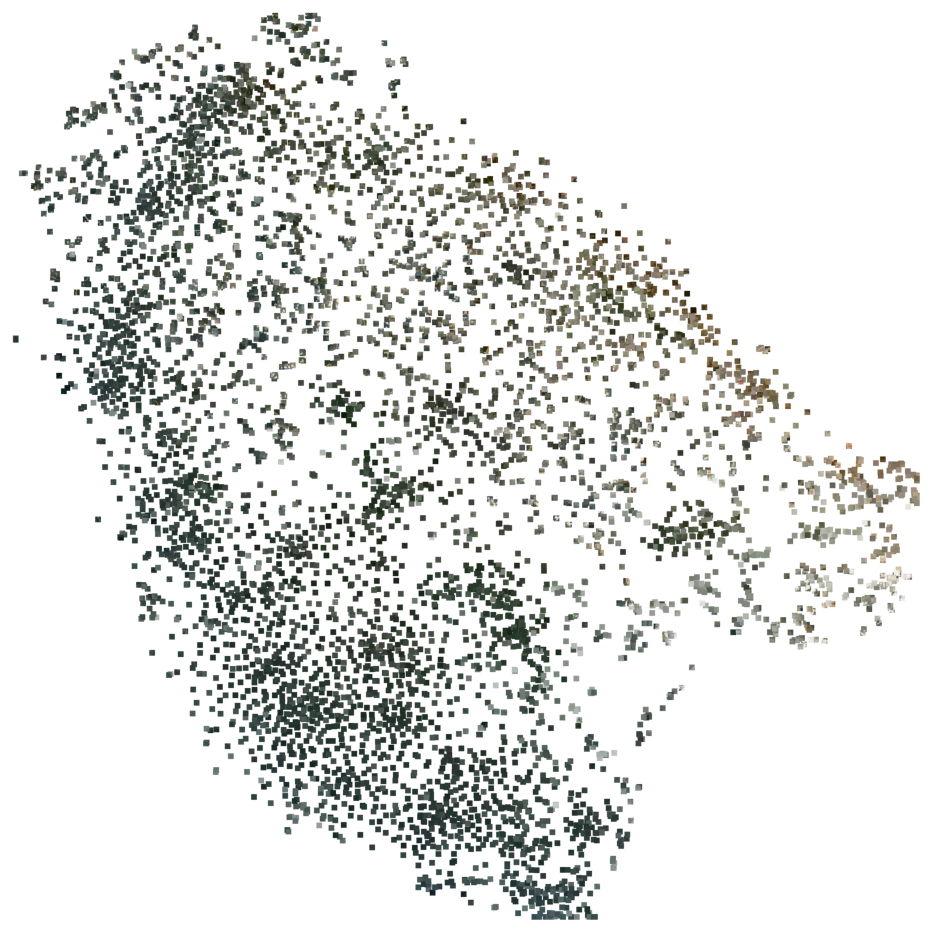

In [15]:
size_img = 8000
offset_img = 50
h = w = int(offset_img / 2)

X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
X_scaled = (X_scaled * size_img).astype(int)
X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

img_tsne = np.ones((size_img+2*offset_img, size_img+2*offset_img, 3), dtype=np.uint8) * 255
for idx in range(X_scaled.shape[0]):
    x, y = X_scaled[idx][0], X_scaled[idx][1]
    img = fetch_img(path_files[idx], h, w)
    img_tsne[x-w:x+w, y-h:y+h, :] = img

fig = plt.figure(figsize=(12, 12))
plt.imshow(img_tsne);
plt.axis("off");

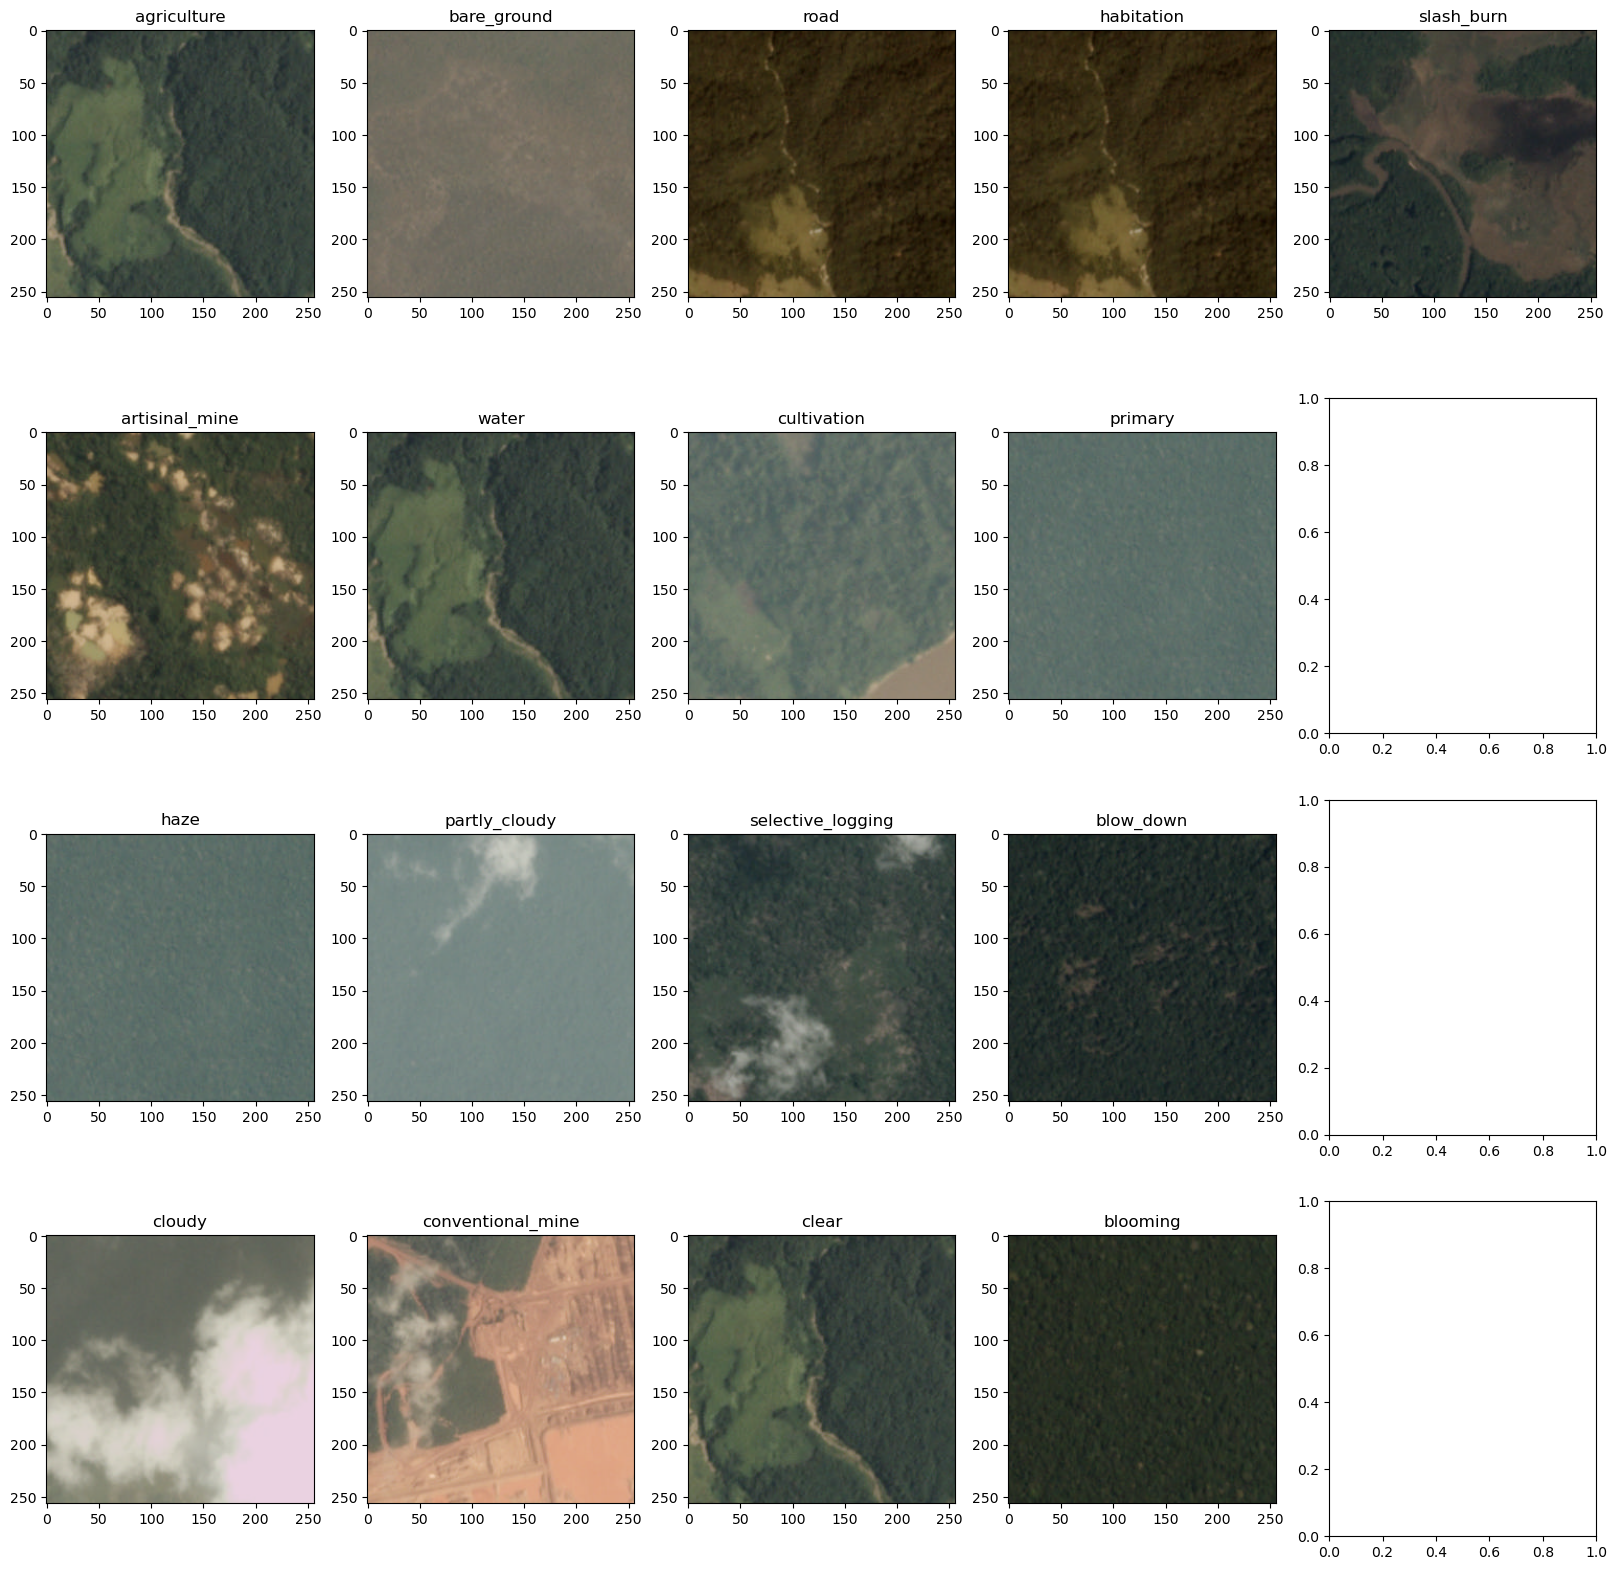

In [9]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)


In [10]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      ),
      T.RandomRotation((90,180)),
      T.RandomVerticalFlip(p=0.5),
      T.RandomHorizontalFlip(p=0.5)
        
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
      ),
      T.RandomRotation((90,180)),
      T.RandomVerticalFlip(p=0.5),
      T.RandomHorizontalFlip(p=0.5)
    ])
    return transform_train, transform_val

In [11]:
class CustomDatasetError(Exception):
    pass


class CustomDataset(Dataset):
    def __init__(self, df, labels, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.labels = labels
        self.transform = transform
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise CustomDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise CustomDatasetError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise CustomDatasetError(f"Can't fetch {filename} among {self.paths}")
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        return img, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
#             img = self.custom_augment(img)
            img = torch.tensor(img)
            img = img.permute(2, 0, 1)
            img = self.transform(img)
            imgs.append(img[None])
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, labels = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {labels}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)
    
   

In [12]:
def get_data(df_train, df_val):
    encoder = MultiLabelBinarizer()
    tags_train = encoder.fit_transform(df_train.list_tags.values)
    tags_val = encoder.transform(df_val.list_tags.values)

    transform_train, transform_val = get_transforms()
    ds_train = CustomDataset(df_train, tags_train, transform_train, path=path_train)
    ds_val = CustomDataset(df_val, tags_val, transform_val, path=path_train)

    dl_train = DataLoader(
      ds_train,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
      ds_val,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_val.collate_fn
    )

    return ds_train, ds_val, dl_train, dl_val, encoder

In [13]:
df_train, df_val = train_test_split(df_class, test_size=.2)


In [14]:
df_class=df_class[0:20000]

In [15]:
df_train, df_val = train_test_split(df_class, test_size=.2)

ds_train, ds_val, dl_train, dl_val, encoder = get_data(df_train, df_val)

# imgs, labels = next(iter(dl_train))
# imgs.shape, labels.shape

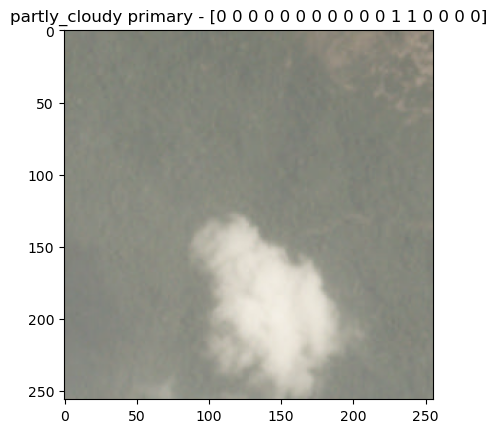

In [16]:
ds_train.load_img(1)

In [17]:
len(dl_train)

250

In [18]:

def get_model():
    model = models.resnet18(weights=False)
    for param in model.parameters():
        param.require_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 128), # 512 for resnet18 or 2048 for resnet 50
      nn.ReLU(inplace=True),
      nn.Dropout(.2),
      nn.Linear(128, 17),
      nn.Sigmoid()
    )
    optimizer = Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()

    return model.to(device), optimizer, loss_fn

In [19]:
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 1.9875% (318)
val bare_ground: 2.0250% (81)

train selective_logging: 0.8500% (136)
val selective_logging: 0.7750% (31)

train artisinal_mine: 0.8000% (128)
val artisinal_mine: 0.9500% (38)

train blooming: 0.7750% (124)
val blooming: 0.7250% (29)

train slash_burn: 0.4688% (75)
val slash_burn: 0.7000% (28)

train blow_down: 0.2750% (44)
val blow_down: 0.2750% (11)

train conventional_mine: 0.2562% (41)
val conventional_mine: 0.2000% (8)



In [20]:
len(dl_train)

250

In [21]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.cpu().detach().numpy()
    
    return Y_hat, batch_loss.item()


def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    Y_hat = Y_hat.cpu().detach().numpy()
    return Y_hat, batch_loss.item()

In [22]:
def class_acc(n_correct,n_samples,n_class_correct,n_class_samples):
    for i in range(17):
      print("-------------------------------------------------")
      acc = 100.0 * n_correct[i] / n_samples
      print(f'Overall class performance: {round(acc,1)} %')
      for k in range(17):
          acc = 100.0 * n_class_correct[i][k] / n_class_samples[i][k]
          print(f'Accuracy of class{i}/{k}: {round(acc,1)} %')
    print("-------------------------------------------------")

In [23]:
def calculate_average_accuracy(Y_train_epoch, Y_thresh_train_epoch):
      correctly_classified_samples=0
      total_number_of_samples=0
      for i in range(len(Y_train_epoch)):
          for k in range(17):
            LY=Y_train_epoch[i][k]
            PY=Y_thresh_train_epoch[i][k]

            if(LY==PY):
              correctly_classified_samples+=1

            total_number_of_samples+=1
    
      return float(100*(correctly_classified_samples/total_number_of_samples))
            



In [ ]:
num_epochs = 10
total_steps = len(dl_train)
# t1 = time.time()
model,optimizer,loss_fn=get_model()
loss_train, loss_val = [], []
score_train, score_val = [], []
Y_hat_val = None
best_loss_val = np.inf
for epoch in range(num_epochs):

    loss_train_epoch, loss_val_epoch = [], []
    Y_hat_train_epoch, Y_hat_val_epoch = [], []
    Y_train_epoch, Y_val_epoch = [], []

    for j, data in enumerate(dl_train):
        images = data[0].to(device)
        outputs = model(images)
        labels =data[1].to(device)
        Y_hat, batch_loss=train_batch(images,labels,model,loss_fn,optimizer)
        loss_train_epoch.append(batch_loss)
        Y_hat_train_epoch.extend(Y_hat)
        Y_train_epoch.extend(labels.detach().float().cpu().numpy())

    for j, data in enumerate(dl_val):
        images = data[0].to(device)
        outputs = model(images)
        labels =data[1].to(device)
        Y_hat, batch_loss = compute_val_loss(images,labels,model,loss_fn)
        loss_val_epoch.append(batch_loss)
        Y_hat_val_epoch.extend(Y_hat)
        Y_val_epoch.extend(labels.detach().float().cpu().numpy())




    avg_loss_train = np.mean(loss_train_epoch)
    avg_loss_val = np.mean(loss_val_epoch)
    Y_hat_train_epoch = np.array(Y_hat_train_epoch)
    Y_hat_val_epoch = np.array(Y_hat_val_epoch)
    Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
    Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
    Y_train_epoch = np.array(Y_train_epoch)
    Y_val_epoch = np.array(Y_val_epoch)

    score_train_epoch = calculate_average_accuracy(Y_train_epoch, Y_thresh_train_epoch)
    score_val_epoch = calculate_average_accuracy(Y_val_epoch, Y_thresh_val_epoch)

    # saving values for debugging
    if avg_loss_val < best_loss_val:
        best_loss_val = avg_loss_val
        Y_hat_val = Y_hat_val_epoch
        Y_thresh_val = Y_thresh_val_epoch
        Y_val = Y_val_epoch
            
    loss_train.append(avg_loss_train)
    loss_val.append(avg_loss_val)
    score_train.append(score_train_epoch)
    score_val.append(score_val_epoch)
    
    print(
            f"epoch: {epoch}/{num_epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
    )

train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }

torch.save(model, f"resnet.pth")
pickle.dump(train_results, open(f"train_results.pkl", "wb"))
    #     outputs = model(images)
    #     # print(outputs.data[0])
    #     Y_thresh_train_epoch = (Y_hat > .5).astype(float)
    #     labels=labels.cpu().detach().numpy()
    #     print(labels)
    #     print(Y_thresh_train_epoch)
    
    #     for i,out in enumerate(outputs):
    #       for k in range(17):
    #         LY=labels[i][k]
    #         PY=Y_thresh_train_epoch[i][k]

    #         if(LY==PY and k==0):
    #           class_0+=1
            
    #         if(k==0):
    #           class_0_samples+=1

    # print(100*class_0/class_0_samples)
        # for i,out in enumerate(outputs):
        #   print(i)
        #   print(out)
          
    #       _, predicted = torch.max(outputs.data,1)
    #       print(predicted)
    #       print(labels[i])
    #       n_correct[i] += (predicted == labels[i]).sum().item()
    #       if i == 0:
    #         n_samples += labels[i].size(0)

    #       for k in range(17):
    #         label = labels[i][k]
    #         pred = predicted[k]
    #         if (label == pred):
    #             n_class_correct[i][label] += 1
    #         n_class_samples[i][label] += 1
    
    # class_acc(n_correct,n_samples,n_class_correct,n_class_samples)
        # Train accuracy
        # total = labels.size(0)
        # _,predicted = torch.Sigmoid(outputs.data)
        # print(labels)
        # print(predicted)
        # correct = (predicted == labels).sum().item()
        # if (j + 1) % 100 == 0:
        #     print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
        #         .format(epoch + 1, num_epochs, j + 1, total_steps, loss.item(),
        #             (correct / total) * 100))
            
# print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

/Users/priyangpatel/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

/var/folders/mz/c6q_6p393sq4xcqpm9k620p00000gn/T/ipykernel_7039/596606872.py:51: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646981653/work/torch/csrc/utils/tensor_new.cpp:233.)



In [ ]:
%ls

In [ ]:
model = torch.load("./resnet.pth")
train_results = pickle.load(open("train_results.pkl", "rb"))

In [ ]:
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
accuracy_train = train_results["accuracy_train"]
accuracy_val = train_results["accuracy_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(accuracy_train))),
        y=accuracy_train,
        name="accuracy_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(accuracy_val))),
        y=accuracy_val,
        name="accuracy_val",
    ),
    row=1, col=2
)
fig.show()

In [ ]:
Y_predicted_val = np.array(train_results["Y_predicted_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_predicted_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_predicted_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(encoder._cached_dict), y=pos_probas, name="Y_predicted proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict), y=neg_probas, name="Y_predicted proba | Y = 0")
]).show()

In [ ]:
def find_best_thresholds(Y_predicted, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in range(N_tags):
        best_score = 0
        #threshs = np.zeros_like(best_threshs)
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_predicted_thresh = (Y_predicted > threshs).astype(float)
            score = calculate_average_accuracy(Y, Y_predicted_thresh)
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx
    
    global_best_score = calculate_average_accuracy(Y, (Y_predicted > best_threshs).astype(float))
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    
    return best_threshs

In [ ]:
threshs = find_best_thresholds(Y_predicted_val, Y_val)


In [ ]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_predicted_val = (Y_predicted_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_predicted_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()

In [ ]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_predicted_val = (Y_predicted_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_predicted_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"], [f"tp: {tp}", f"fp: {fp}"]], 
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row, 
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)
    

fig.update_layout(
    width=1200, height=800, title="Confusion matrices", 
)
fig.show()